In [7]:
import requests
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import pandas as pd
from database import Persistence
import plotly.io as pio
from pywaffle import Waffle
import matplotlib.pyplot as plt
pio.renderers.default = "vscode"

base_link = 'https://pm.gc.ca/en/videos?page=0'
root = 'https://pm.gc.ca'

In [2]:
base_html = BeautifulSoup(requests.get(base_link).content, 'lxml')
last_link = base_html.find('li', {'class':'pager__item pager__item--last'}).find('a').get('href')
last_page_num = re.search(r'[0-9]+', last_link).group()

In [3]:
video_links = []
for i in range(0, int(last_page_num) + 1):
    num = str(i)
    data = requests.get(f'https://pm.gc.ca/en/videos/get_vids?page={num}').json()['vids']
    for video in data:
        video_links.append({
            'link':root + video['url'],
            'date':video['date']})

In [5]:
video_links[0]

{'link': 'https://pm.gc.ca/en/videos/2021/07/08/remarks-announcing-historic-first-early-learning-and-child-care-agreement-british',
 'date': 'Jul 8, 2021'}

In [7]:
def filter_text(text):
    return text.replace('\xa0', '').replace('\n', '')


def get_text(dict_item):
    link = dict_item['link']
    soup = BeautifulSoup(requests.get(link).content, 'lxml')
    title = soup.find('div', {'class':'title-header-inner'}).text
    soup_text = soup.find('div', {'class':'content'}).find_all('div')
    if len(soup_text)==2:
        soup_text = filter_text(soup_text[1].text)
    else:
        soup_text = ''
    return {
        'title': filter_text(title),
        'text': soup_text,
        'date': dict_item['date']
    }  


In [8]:
data = [get_text(x) for x in tqdm(video_links)]

100%|██████████| 638/638 [08:54<00:00,  1.19it/s]


In [15]:
pd.DataFrame(data).columns

Index(['title', 'video_text', 'date'], dtype='object')

In [9]:
data = pd.DataFrame(data).rename(columns={'text':'video_text'}).to_dict('records')

In [16]:
# Persistence.write_pm_vid_data(data, 'pm_video_text_sam')
# print('done!')
from database import CursorFromConnectionFromPool
from psycopg2 import sql

with CursorFromConnectionFromPool() as cur:
    try:
        create_table_query = sql.SQL(""" 
            CREATE TABLE IF NOT EXISTS pm_speeches (
                title text UNIQUE,
                video_text text,
                date text
            );

            ALTER TABLE pm_speeches OWNER TO rds_ad;
        """)
        cur.execute(create_table_query)
        cur.connection.commit()
    except Exception as e:
        print(f'An exception occured executting a query: \n{e}')
        cur.connection.rollback()
    insert_legislator_query = sql.SQL("""
        INSERT INTO pm_speeches
        VALUES (%s, %s, %s)
        ON CONFLICT (title) DO UPDATE SET
            video_text = excluded.video_text,
            date = excluded.date
        """)

    for item in data:
        try:
            tup = (
                item['title'],
                item['video_text'],
                item['date']
            )

            cur.execute(insert_legislator_query, tup)
        except Exception as e:
            print(f'Exception occured inserting the following data:\n{tup}')
            print(e)
            cur.connection.rollback()
    print('done!')
    

done!


In [2]:

from database import Persistence, CursorFromConnectionFromPool
from datetime import datetime
import pandas as pd
from psycopg2 import sql

with CursorFromConnectionFromPool() as cur:
    try:
        pm_data = pd.read_sql("SELECT * FROM pm_speeches", cur.connection)
        cur.connection.commit()
    except Exception as e:
        print(f'An exception occured executing a query: \n{e}')

pm_data_dict = pm_data.to_dict('records')

In [27]:
# date_dict = {}
# for item in pm_data_dict:
#     key = item['date'].split(',')[-1].strip()
#     if key in date_dict:
#         date_dict[key]+=1
#     else:
#         date_dict[key]=1
# date_dict
all_keys = list(pm_data_dict[0]['with_title'].keys())
all_keys_dict = {}
for i in range(len(all_keys)):
    all_keys_dict[all_keys[i]] = 0
all_keys_dict

{'education': 0,
 'social welfare': 0,
 'public lands': 0,
 'civil rights': 0,
 'housing': 0,
 'environment': 0,
 'macroeconomics': 0,
 'health': 0,
 'transportation': 0,
 'energy': 0,
 'government operations': 0,
 'labour': 0,
 'domestic commerce': 0,
 'immigration': 0,
 'international affairs': 0,
 'law and crime': 0,
 'foreign trade': 0,
 'agriculture': 0,
 'defense': 0,
 'technology': 0,
 'informal': 0}

In [3]:
def filter_data_by_year(data_dict, year):
    str_year = str(year)
    return_lst = []
    for item in data_dict:
        if item['date'].split(',')[-1].strip() == str_year:
            return_lst.append(item)
    return return_lst

data_2015 = filter_data_by_year(pm_data_dict, 2015)
data_2016 = filter_data_by_year(pm_data_dict, 2016)
data_2017 = filter_data_by_year(pm_data_dict, 2017)
data_2018 = filter_data_by_year(pm_data_dict, 2018)
data_2019 = filter_data_by_year(pm_data_dict, 2019)
data_2020 = filter_data_by_year(pm_data_dict, 2020)
data_2021 = filter_data_by_year(pm_data_dict, 2021)


In [4]:
def get_main_topic(data):
    all_keys = list(pm_data_dict[0]['with_title'].keys())
    all_keys_dict = {}
    for i in range(len(all_keys)):
        all_keys_dict[all_keys[i]] = 0
    for item in data:
        if item['main_topic'] in all_keys_dict:
            all_keys_dict[item['main_topic']] += 1
    return all_keys_dict

print(f'{get_main_topic(data_2021)} \n {get_main_topic(data_2016)}')

{'education': 2, 'social welfare': 3, 'public lands': 1, 'civil rights': 3, 'housing': 3, 'environment': 0, 'macroeconomics': 0, 'health': 34, 'transportation': 1, 'energy': 1, 'government operations': 0, 'labour': 0, 'domestic commerce': 1, 'immigration': 0, 'international affairs': 0, 'law and crime': 1, 'foreign trade': 0, 'agriculture': 0, 'defense': 0, 'technology': 0, 'informal': 0} 
 {'education': 7, 'social welfare': 7, 'public lands': 3, 'civil rights': 15, 'housing': 0, 'environment': 3, 'macroeconomics': 3, 'health': 2, 'transportation': 5, 'energy': 7, 'government operations': 0, 'labour': 4, 'domestic commerce': 4, 'immigration': 3, 'international affairs': 13, 'law and crime': 1, 'foreign trade': 8, 'agriculture': 0, 'defense': 2, 'technology': 0, 'informal': 3}


In [5]:
main_topics_2021 = get_main_topic(data_2021)
main_topics_2020 = get_main_topic(data_2020)
main_topics_2019 = get_main_topic(data_2019)
main_topics_2018 = get_main_topic(data_2018)
main_topics_2017 = get_main_topic(data_2017)
main_topics_2016 = get_main_topic(data_2016)
main_topics_2015 = get_main_topic(data_2015)


In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots



fig = make_subplots(rows=1, cols=5, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}, {'type':'domain'}, {'type':'domain'}]], 
                    subplot_titles=['2021', '2020', '2019', '2018', '2017'])

fig.add_trace(go.Pie(labels = list(main_topics_2021.keys()), values=list(main_topics_2021.values())), 1, 1)

fig.add_trace(go.Pie(labels = list(main_topics_2020.keys()), values=list(main_topics_2020.values())), 1, 2)

fig.add_trace(go.Pie(labels = list(main_topics_2019.keys()), values=list(main_topics_2019.values())), 1, 3)

fig.add_trace(go.Pie(labels = list(main_topics_2018.keys()), values=list(main_topics_2018.values())), 1, 4)

fig.add_trace(go.Pie(labels = list(main_topics_2017.keys()), values=list(main_topics_2017.values())), 1, 5)




fig.update_traces(hole=0.4)

fig.update_layout(
    title_text = 'Main Topics from Justin Trudeau'
)

fig.show()

In [53]:
# for item in list(main_topics_2015.keys()):
 #    fprint(item)
icons = ['user-graduate', 'user-plus', 'image', 'users', 'home', 'leaf', 'chart-line', 'heartbeat', 'road', 'bolt', 'forward', 'hardhat', 'money-bill-wave', 'plane-arrival', 'globe-americas', 'balance-scale', 'exchange-alt', 'tractor', 'shield-alt', 'laptop-code', 'circle']
main_topics = list(main_topics_2015.keys())
icons_dict = {}
for i in range(len(icons)):
    icons_dict[main_topics[i]] = icons[i]
icons_dict

{'education': 'user-graduate',
 'social welfare': 'user-plus',
 'public lands': 'image',
 'civil rights': 'users',
 'housing': 'home',
 'environment': 'leaf',
 'macroeconomics': 'chart-line',
 'health': 'heartbeat',
 'transportation': 'road',
 'energy': 'bolt',
 'government operations': 'forward',
 'labour': 'hardhat',
 'domestic commerce': 'money-bill-wave',
 'immigration': 'plane-arrival',
 'international affairs': 'globe-americas',
 'law and crime': 'balance-scale',
 'foreign trade': 'exchange-alt',
 'agriculture': 'tractor',
 'defense': 'shield-alt',
 'technology': 'laptop-code',
 'informal': 'circle'}

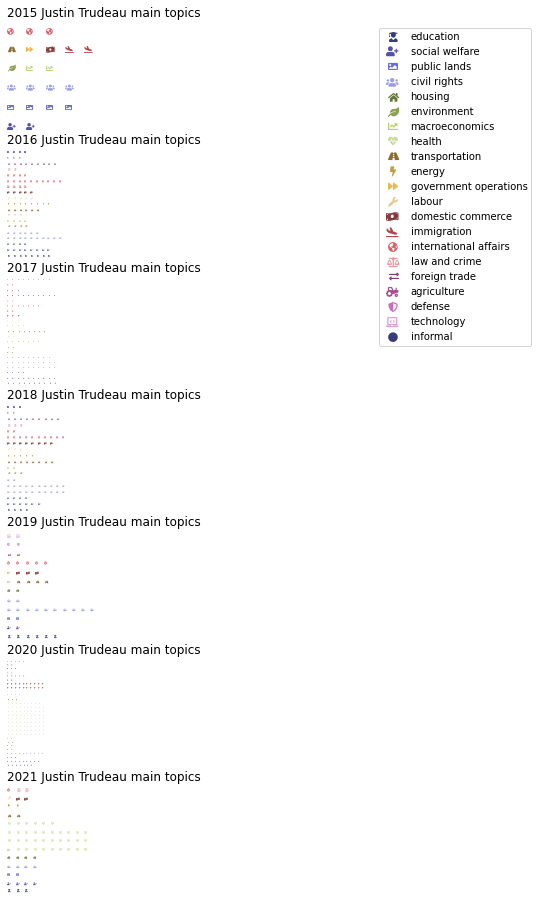

In [126]:
icons_lst = ['user-graduate', 'user-plus', 'image', 'users', 'home', 'leaf', 'chart-line', 'heartbeat', 'road', 'bolt', 'forward', 'wrench', 'money-bill-wave', 'plane-arrival', 'globe-americas', 'balance-scale', 'exchange-alt', 'tractor', 'shield-alt', 'laptop-code', 'circle']

fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '711': {
            'values': list(main_topics_2015.values()),
            'labels': list(main_topics_2015.keys()),
            'legend': {
                'loc': 'upper left',
                'bbox_to_anchor': (2, 1),
                'fontsize': 10
            },
            'title': {
                'label': '2015 Justin Trudeau main topics',
                'loc': 'left'
            }
        },
        '712': {
            'values': list(main_topics_2016.values()),
            'title': {
                'label': '2016 Justin Trudeau main topics',
                'loc': 'left'
            },
            'legend': {
                'loc': 'upper left',
                'bbox_to_anchor': (1,1),
                'fontsize':0
            }
        },
        '713': {
            'values': list(main_topics_2017.values()),
            'title': {
                'label': '2017 Justin Trudeau main topics',
                'loc': 'left'
            },
            'legend': {
                'loc': 'upper left',
                'bbox_to_anchor': (1, 1),
                'fontsize': 0
            },
        },
        '714': {
            'values': list(main_topics_2018.values()),
            'title': {
                'label': '2018 Justin Trudeau main topics',
                'loc': 'left'
            },
            'legend': {
                'loc': 'upper left',
                'bbox_to_anchor': (1, 1),
                'fontsize': 0
            },
        },
        '715': {
            'values': list(main_topics_2019.values()),
            'title': {
                'label': '2019 Justin Trudeau main topics',
                'loc': 'left'
            }
        },
        '716': {
            'values': list(main_topics_2020.values()),
            'title': {
                'label': '2020 Justin Trudeau main topics',
                'loc': 'left'
            }
        },
        '717': {
            'values': list(main_topics_2021.values()),
            'title': {
                'label': '2021 Justin Trudeau main topics',
                'loc': 'left'
            }
        }
    },
    tight=False,
    columns=10,
    cmap_name='tab20b',
    interval_ratio_x = 1,
    interval_ratio_y = 1,
    icons = icons_lst,
    icon_legend=True,
    block_arranging_style='new-line',
    vertical=True,
    figsize=(20,16)
)



In [56]:
def get_waffle_topic(topic_dict, key):
    total = sum(list(topic_dict.values()))
    num_from_key = topic_dict[key]
    percentage = round(num_from_key / total, 2) * 50
    return [percentage, 50 - percentage]

# info = get_waffle_topic(main_topics_2020, 'health')

# fig = plt.figure(
#     FigureClass=Waffle,
#     columns=10,
#     values=info,
#     interval_ratio_x = 0.3,
#     interval_ratio_y = 0.5,
#     block_arranging_style='new-line',
#     icons= ['heartbeat', 'circle'],
#     cmap_name = 'Pastel1',
#     title={
#         'label':'2020 Health Topics',
#         'loc': 'left',
#         'fontsize':16
#     },
#     legend={
#         'labels':['Health', 'Other'],
#         'loc': 'upper right',
#         'bbox_to_anchor': (1.7, 1)
#     },
#     icon_legend=True
# )


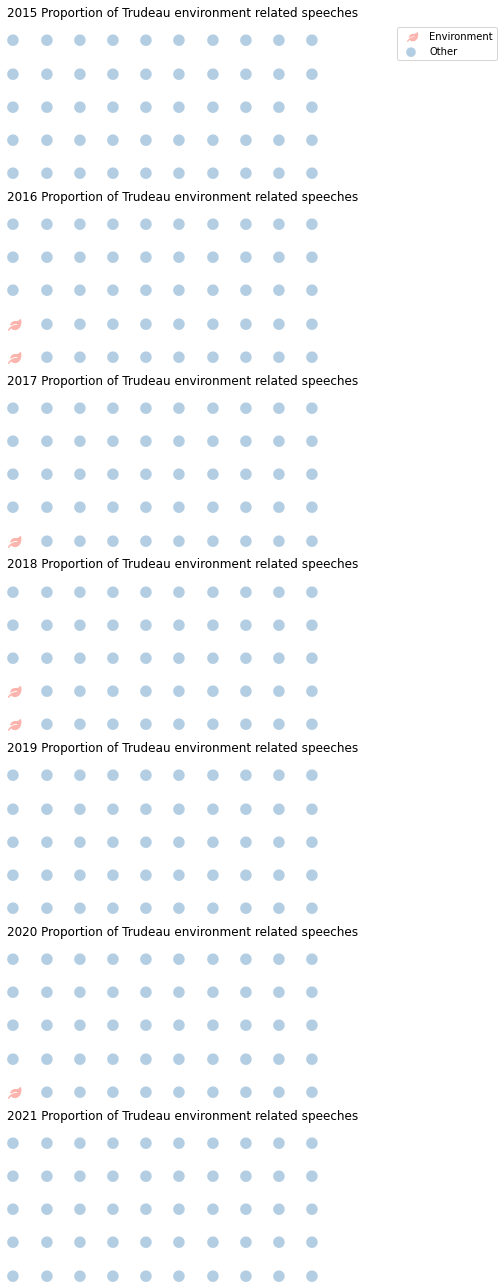

In [66]:
topic = 'environment'

info_2015 = get_waffle_topic(main_topics_2015, topic)
info_2016 = get_waffle_topic(main_topics_2016, topic)
info_2017 = get_waffle_topic(main_topics_2017, topic)
info_2018 = get_waffle_topic(main_topics_2018, topic)
info_2019 = get_waffle_topic(main_topics_2019, topic)
info_2020 = get_waffle_topic(main_topics_2020, topic)
info_2021 = get_waffle_topic(main_topics_2021, topic)

fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '711': {
            'values': info_2015,
            'labels': [f'{topic.title()}', 'Other'],
            'legend': {
                'loc': 'upper left',
                'bbox_to_anchor': (1.2, 1),
                'fontsize': 10
            },
            'title': {
                'label': f'2015 Proportion of Trudeau {topic} related speeches',
                'loc': 'left'
            }
        },
        '712': {
            'values': info_2016,
            'title': {
                'label': f'2016 Proportion of Trudeau {topic} related speeches',
                'loc': 'left'
            },
            'legend': {
                'loc': 'upper left',
                'bbox_to_anchor': (1,1),
                'fontsize':0
            }
        },
        '713': {
            'values': info_2017,
            'title': {
                'label': f'2017 Proportion of Trudeau {topic} related speeches',
                'loc': 'left'
            },
            'legend': {
                'loc': 'upper left',
                'bbox_to_anchor': (1, 1),
                'fontsize': 0
            },
        },
        '714': {
            'values': info_2018,
            'title': {
                'label': f'2018 Proportion of Trudeau {topic} related speeches',
                'loc': 'left'
            },
            'legend': {
                'loc': 'upper left',
                'bbox_to_anchor': (1, 1),
                'fontsize': 0
            },
        },
        '715': {
            'values': info_2019,
            'title': {
                'label': f'2019 Proportion of Trudeau {topic} related speeches',
                'loc': 'left'
            }
        },
        '716': {
            'values': info_2020,
            'title': {
                'label': f'2020 Proportion of Trudeau {topic} related speeches',
                'loc': 'left'
            }
        },
        '717': {
            'values': info_2021,
            'title': {
                'label': f'2021 Proportion of Trudeau {topic} related speeches',
                'loc': 'left'
            }
        }
    },
    # tight=False,
    rows=5,
    cmap_name='Pastel1',
    interval_ratio_x = 0.5,
    interval_ratio_y = 0.5,
    icons = [f'{icons_dict[topic]}','circle'],
    icon_legend=True,
    block_arranging_style='snake',
    figsize=(22,18)
)